In [11]:
# Given a mask_coverage, a mask and the raw image data.
# This notebook will generate a training dataset

In [12]:
BASE_DIR = '/projects/bachelor-thesis'
TMP_DIR = '/projects/bachelor-thesis/tmp'

In [13]:
import os

MAKS_PATH = '/data/masks'
dates = os.listdir(BASE_DIR + MAKS_PATH)
dates.sort()
dates

['20210720T101559',
 '20210819T101559',
 '20210908T101559',
 '20211018T101939',
 '20211227T102339']

In [14]:
import numpy as np
import rasterio


# Load the mask_coverage and the mask
def load_mask_coverage(_date):
    mask_coverage_path = BASE_DIR + MAKS_PATH + '/' + _date + '/mask_coverage.jp2'
    return rasterio.open(mask_coverage_path)


# Load the mask
def load_mask(_date):
    mask_path = BASE_DIR + MAKS_PATH + '/' + _date + '/mask.jp2'
    return rasterio.open(mask_path)


# choose a random date
date = np.random.choice(dates)

# date to human-readable
date_str = date[6:8] + '.' + date[4:6] + '.' + date[0:4]

mask_coverage = load_mask_coverage(date)
mask = load_mask(date)

# Plot the mask_coverage and the mask
mask_coverage_data = mask_coverage.read(1)
mask_data = mask.read(1)

In [15]:
import rasterio

description = ["Coastal aerosol", "Blue", "Green", "Red", "Vegetation Red Edge 1", "Vegetation Red Edge 2",
               "Vegetation Red Edge 3", "NIR", "Vegetation Red Edge 4", "Water vapour", "SWIR - Cirrus",
               "SWIR 1", "SWIR 2", "True Color Image"]

MSK_CLDPRB_20m = "MSK_CLDPRB_20m.jp2"
MSK_CLDPRB_60m = "MSK_CLDPRB_60m.jp2"
MSK_SNWPRB_20m = "MSK_SNWPRB_20m.jp2"
MSK_SNWPRB_60m = "MSK_SNWPRB_60m.jp2"

# Search for a folder starting with "S2B_MSIL1C_$DATE"
FOLDER = !ls $TMP_DIR | grep "S2B_MSIL1C_$date"
FOLDER = FOLDER[0]

BASE_PATH = f"{TMP_DIR}/{FOLDER}/GRANULE/"

# list all subfolders of the base path
SUBFOLDER = !ls $BASE_PATH
BASE_PATH += '/' + SUBFOLDER[0] + '/IMG_DATA'

B01 = f"T32TNS_{date}_B01.jp2"
B02 = f"T32TNS_{date}_B02.jp2"
B03 = f"T32TNS_{date}_B03.jp2"
B04 = f"T32TNS_{date}_B04.jp2"
B05 = f"T32TNS_{date}_B05.jp2"
B06 = f"T32TNS_{date}_B06.jp2"
B07 = f"T32TNS_{date}_B07.jp2"
B08 = f"T32TNS_{date}_B08.jp2"
B8A = f"T32TNS_{date}_B8A.jp2"
B09 = f"T32TNS_{date}_B09.jp2"
B10 = f"T32TNS_{date}_B10.jp2"
B11 = f"T32TNS_{date}_B11.jp2"
B12 = f"T32TNS_{date}_B12.jp2"
TCI = f"T32TNS_{date}_TCI.jp2"

bands_files = [B01, B02, B03, B04, B05, B06, B07, B08, B8A, B09, B10, B11, B12, TCI]
bands_files = [f"{BASE_PATH}/{band}" for band in bands_files]

# Open all the bands
bands = [rasterio.open(band) for band in bands_files]

# add description to bands
for i, band in enumerate(bands):
    band.description = description[i]
    bands[i] = band

band_B01 = bands[0]
band_B02 = bands[1]
band_B03 = bands[2]
band_B04 = bands[3]
band_B05 = bands[4]
band_B06 = bands[5]
band_B07 = bands[6]
band_B08 = bands[7]
band_B8A = bands[8]
band_B09 = bands[9]
band_B10 = bands[10]
band_B11 = bands[11]
band_B12 = bands[12]
band_TCI = bands[13]

# Search for a folder starting with "S2B_MSIL1C_$DATE"
FOLDER = !ls $TMP_DIR | grep "S2B_MSIL2A_$date"
FOLDER = FOLDER[0]

BASE_PATH = f"{TMP_DIR}/{FOLDER}/GRANULE/"

# list all subfolders of the base path
SUBFOLDER = !ls $BASE_PATH
BASE_PATH += '/' + SUBFOLDER[0] + '/QI_DATA'

mask_cldprb_20m = rasterio.open(f"{BASE_PATH}/{MSK_CLDPRB_20m}")
mask_cldprb_60m = rasterio.open(f"{BASE_PATH}/{MSK_CLDPRB_60m}")
mask_snwprb_20m = rasterio.open(f"{BASE_PATH}/{MSK_SNWPRB_20m}")

In [16]:
IMG_SIZE = 128

In [17]:
# load band_TCI
band_TCI_data = band_TCI.read()

In [18]:
# sample a random patch from the mask_coverage
# where the mask_coverage is 1
def sample_patch(_mask_coverage):
    # sample a random patch
    _x = np.random.randint(0, _mask_coverage.shape[0] - IMG_SIZE)
    _y = np.random.randint(0, _mask_coverage.shape[1] - IMG_SIZE)

    # check if the patch is valid
    if np.sum(_mask_coverage[_x:_x + IMG_SIZE, _y:_y + IMG_SIZE]) == IMG_SIZE ** 2:
        return _x, _y
    else:
        return sample_patch(_mask_coverage)

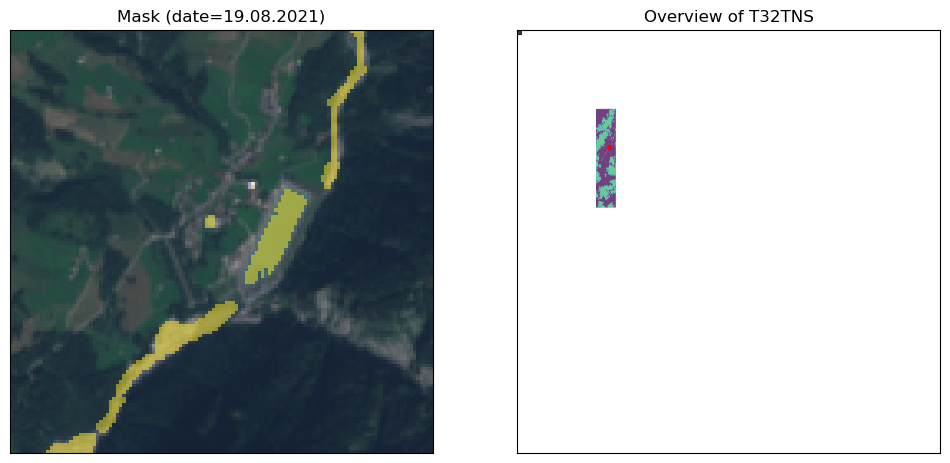

In [20]:
from matplotlib import patches
from rasterio.plot import show
import matplotlib.pyplot as plt

x, y = sample_patch(mask_coverage_data)

mask_patch = mask_data[x:x + IMG_SIZE, y:y + IMG_SIZE]
band_TCI_patch = band_TCI_data[:, x:x + IMG_SIZE, y:y + IMG_SIZE]

# Plot the mask as overlay to the TCI image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
show(band_TCI_patch, ax=ax[0])

# Clamp the mask to [0, 1] to make it visible
ax[0].imshow(mask_patch, alpha=np.clip(mask_patch.copy(), 0, 1) * 0.5)
ax[0].set_title('Mask (date={})'.format(date_str))
ax[0].set_xticks([])
ax[0].set_yticks([])
show(band_TCI_patch, ax=ax[1])

# mark the area in the full image
plt.imshow(mask_data, alpha=mask_coverage_data * 0.75)
ax[1].set_title('Overview of T32TNS')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].add_patch(patches.Rectangle((y, x), IMG_SIZE, IMG_SIZE, facecolor='r'))
plt.show()

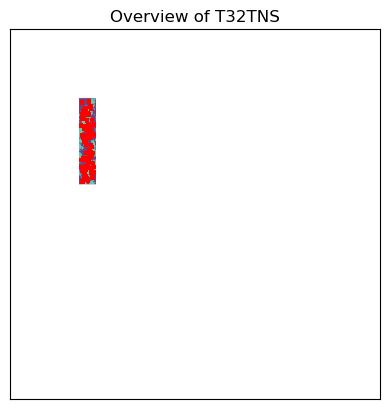

In [28]:
# Temp folder to store the patches
TMP_PATCH_DIR = f"{TMP_DIR}/patches"
!mkdir -p $TMP_PATCH_DIR

# clear the folder
!rm -rf $TMP_PATCH_DIR/*

centers = []

# Create 100 patches and save them
for i in range(100):
    x, y = sample_patch(mask_coverage_data)
    centers.append((x, y))

    mask_patch = mask_data[x:x + IMG_SIZE, y:y + IMG_SIZE]
    band_TCI_patch = band_TCI_data[:, x:x + IMG_SIZE, y:y + IMG_SIZE]

    # Save the mask
    mask_patch_path = f"{TMP_PATCH_DIR}/mask_{i}.png"
    plt.imsave(mask_patch_path, mask_patch)

    # Save the TCI image
    band_TCI_patch_path = f"{TMP_PATCH_DIR}/band_TCI_{i}.png"
    plt.imsave(band_TCI_patch_path, band_TCI_patch.transpose(1, 2, 0))

# Show an overview of the centers
plt.imshow(mask_data, alpha=mask_coverage_data * 0.75)
plt.title('Overview of T32TNS')
plt.xticks([])
plt.yticks([])
for x, y in centers:
    plt.gca().add_patch(patches.Rectangle((y, x), IMG_SIZE, IMG_SIZE, facecolor='r'))

plt.show()